In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 13.2 Hidden Markov Models

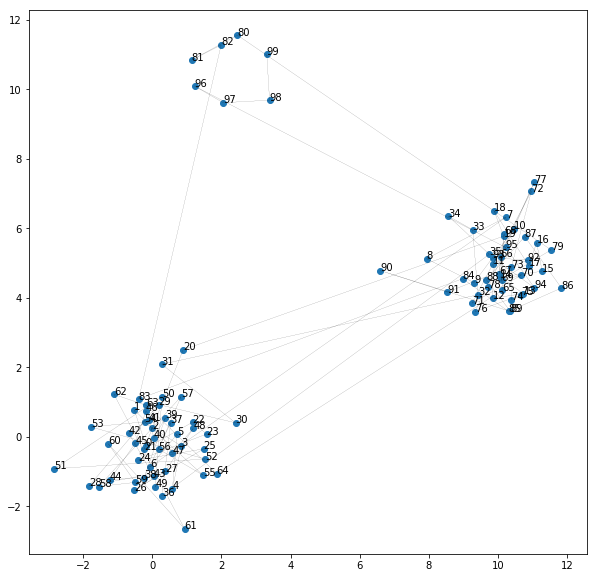

In [19]:
initial_prob = np.ones(3) / 3
transition_prob = np.array([[.9, .05, .05], [.05, .9, .05], [.05, .05, .9]])
means = np.array([[0, 0], [2, 10], [10, 5]])
covs = np.asarray([np.eye(2) for _ in range(3)])
precisions = np.linalg.inv(covs)
ndims = means.shape[1]
n_hidden = 3

n = 100
hidden_state = np.random.choice(n_hidden,  p = initial_prob)
seq = []
while len(seq) < n:
    x = np.random.multivariate_normal(means[hidden_state], covs[hidden_state], 1)
    seq.extend(x)
    hidden_state = np.random.choice(n_hidden, p = transition_prob[hidden_state])
    
seq = np.asarray(seq)
plt.figure(figsize=(10, 10))
plt.scatter(seq[:, 0], seq[:, 1])
plt.plot(seq[:, 0], seq[:, 1], "k", linewidth=0.1)
for i, p in enumerate(seq):
    plt.annotate(str(i), p)

In [ ]:
max_iter = 100

for i in range(max_iter):
    